Source of map tiles: © GeoBasis-DE / [BKG](https://www.bkg.bund.de/) (2025) [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)

In [1]:
import os, sys
from dotenv import load_dotenv

ROOT_DIR = os.path.abspath("..")
DATA_DIR = os.path.join(ROOT_DIR, "data")

load_dotenv(os.path.join(ROOT_DIR, ".env"))

sys.path.append(ROOT_DIR)

In [7]:
from shapely.geometry import box, Point, Polygon
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
import pandas as pd
import geopandas as gpd
import geopy
import numpy as np
import pyproj
import tilemapbase

from random_qa.graph.loader import (
    load_sites_dataframe,
    load_mobile_antennas_dataframe,
    load_microwave_antennas_dataframe,
    load_cells_dataframe,
    load_tiles_dataframe,
    load_regions_dataframe,
    load_services_dataframe,
    load_buildings_dataframe,
    load_pois_dataframe,
    load_operators_dataframe,
    load_manufacturers_dataframe,
)
from random_qa.graph.heuristics import compute_site_connection, compute_cell_coverage

from random_qa.utils import CRS_ETRS89_UTM33N, CRS_WEBMERCATOR, CRS_WGS84_GPS, plot_tilemap
from random_qa.cli import init_env

plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
tilemapbase.init(create=True)
init_env()

Loaded tqdm widget for notebooks

In [3]:
df_services = load_services_dataframe()
df_manufacturers = load_manufacturers_dataframe()
df_operators = load_operators_dataframe()
gdf_sites = load_sites_dataframe(DATA_DIR)
gdf_sites = compute_site_connection(gdf_sites)
gdf_pois = load_pois_dataframe(DATA_DIR)
gdf_mobile_antennas = load_mobile_antennas_dataframe(DATA_DIR, gdf_sites)
gdf_microwave_antennas = load_microwave_antennas_dataframe(gdf_sites, df_manufacturers)
gdf_regions = load_regions_dataframe(DATA_DIR)
gdf_buildings = load_buildings_dataframe(DATA_DIR)
gdf_tiles = load_tiles_dataframe(gdf_regions)
gdf_cells = load_cells_dataframe(DATA_DIR, gdf_mobile_antennas, df_services)
gdf_cells = compute_cell_coverage(gdf_cells, gdf_tiles, gdf_buildings, df_services)

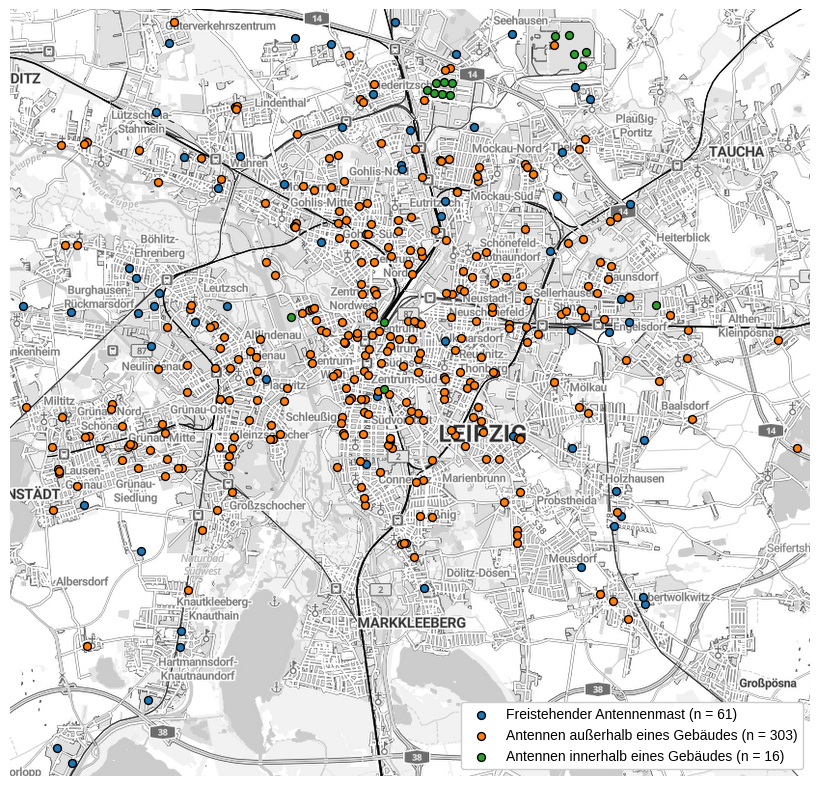

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_axis_off()
fig.tight_layout(pad=0)
construction_type_translation = {
    "Freestanding": "Freistehender Antennenmast",
    "Building": "Antennen außerhalb eines Gebäudes",
    "Indoor": "Antennen innerhalb eines Gebäudes",
}
scope = gdf_sites.to_crs(CRS_WEBMERCATOR).union_all().convex_hull.buffer(500)
p = gdf_sites.construction.value_counts(normalize=False)
plot_tilemap(ax, scope)
for construction in construction_type_translation.keys():
    gdf_sites[gdf_sites.construction == construction] \
        .to_crs(CRS_WEBMERCATOR) \
        .plot(ax=ax, marker="o", markersize=32, label=f"{construction_type_translation[construction]} (n = {p[construction]:d})", edgecolor="black")

ax.legend().get_frame().set_alpha(1)

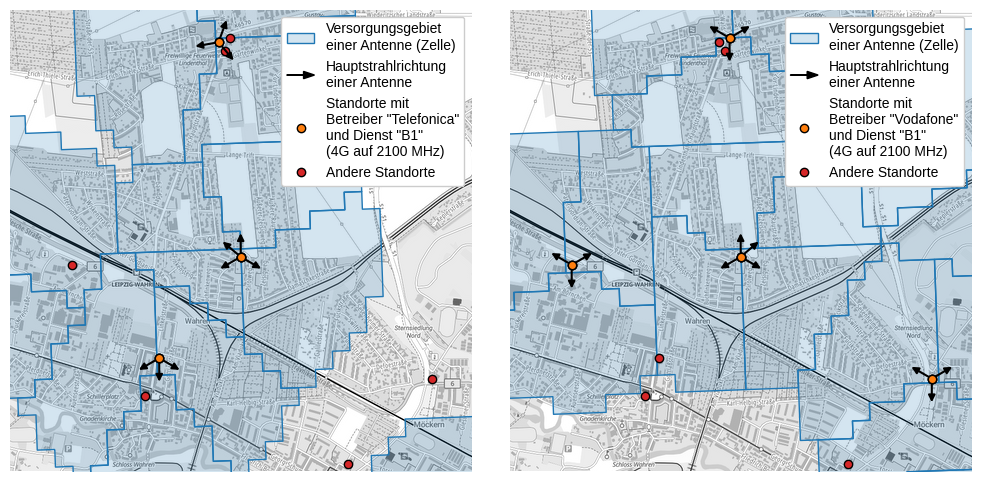

In [9]:
def make_legend_arrow(*, width, height, **kwargs):
    p = mpatches.FancyArrow(0, 0.5*height, width, 0, length_includes_head=True, head_width=0.75*height, linewidth=3)
    return p

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
transformer = pyproj.Transformer.from_crs(CRS_WEBMERCATOR, CRS_WGS84_GPS)
def plot_cells(ax: Axes, area_of_interest: Polygon, operator: str, service: str):
    ax.set_axis_off()
    plot_tilemap(ax, area_of_interest)

    gdf_cells_filtered = gdf_cells[
        (gdf_cells.antenna_operated_by == f"Operator:{operator}") &
        (gdf_cells.service == f"Service:{service}")
    ].to_crs(CRS_WEBMERCATOR)

    gdf_cells_filtered = gdf_cells_filtered[gdf_cells_filtered.within(area_of_interest.buffer(1000))]

    for site in gdf_sites[~gdf_sites.index.isin(gdf_cells_filtered.antenna_installed_at)].to_crs(CRS_WEBMERCATOR).geometry:
        ax.plot(site.x, site.y, color="tab:red", marker="o", markersize=6, markeredgecolor="black", zorder=1.5)
    
    for _, row in gdf_cells_filtered.iterrows():
        site = gdf_sites.to_crs(CRS_WEBMERCATOR).loc[row.antenna_installed_at]
        antenna = gdf_mobile_antennas.loc[row.served_by]

        if not pd.isna(antenna.orientation):
            arrow_base_pos = (site.geometry.x, site.geometry.y)
            arrow_head_pos = transformer.transform(*geopy.distance.distance(meters=150).destination(
                point=transformer.transform(*arrow_base_pos),
                bearing=antenna.orientation
            )[:2], direction="INVERSE")
            
            arrow = gpd.GeoSeries(map(lambda x: Point(*x), [arrow_base_pos, arrow_head_pos]), crs=CRS_WEBMERCATOR)
            if arrow.within(area_of_interest).all():
                ax.annotate("",
                    xytext=arrow_base_pos,
                    xy=arrow_head_pos,
                    arrowprops=dict(arrowstyle="-|>", linewidth=1.5, facecolor="black", edgecolor="black"),
                    zorder=2,
                    annotation_clip=False,
                    clip_on=True
                )

        ax.plot(site.geometry.x, site.geometry.y, marker="o", color="tab:orange", markersize=6, markeredgecolor="black", zorder=3)

        if row.covered_tiles is None:
            continue
        cell = gdf_tiles.loc[row.covered_tiles].union_all()
        gpd.GeoSeries([cell], crs=CRS_ETRS89_UTM33N) \
            .to_crs(CRS_WEBMERCATOR) \
            .plot(ax=ax, edgecolor="tab:blue", facecolor=mcolors.TABLEAU_COLORS["tab:blue"] + "30", zorder=1)

    ax.legend(handles=[
        mpatches.Patch(edgecolor="tab:blue", facecolor=mcolors.TABLEAU_COLORS["tab:blue"] + "30", label="Versorgungsgebiet\neiner Antenne (Zelle)"),
        mpatches.FancyArrow(0, 0, 0, 0, edgecolor="black", facecolor="black", label="Hauptstrahlrichtung\neiner Antenne"),
        mlines.Line2D([], [], marker="o", linewidth=0, color="tab:orange", markersize=6, markeredgecolor="black", label=f"Standorte mit\nBetreiber \"{provider}\"\nund Dienst \"{service}\"\n(4G auf 2100 MHz)"),
        mlines.Line2D([], [], marker="o", linewidth=0, color="tab:red", markersize=6, markeredgecolor="black", label="Andere Standorte")
    ], handler_map={mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow)}).get_frame().set_alpha(1)

center_x, center_y = transformer.transform(51.38166, 12.32996, direction="INVERSE")
offset = 2100
extent = box(center_x - offset, center_y - offset + 150, center_x + offset, center_y + offset + 150)
fig.tight_layout(pad=0)

for i, provider in enumerate(["Telefonica", "Vodafone"]):
    ax: Axes = axs[np.unravel_index(i, axs.shape)]
    plot_cells(ax, extent, provider, "B1")

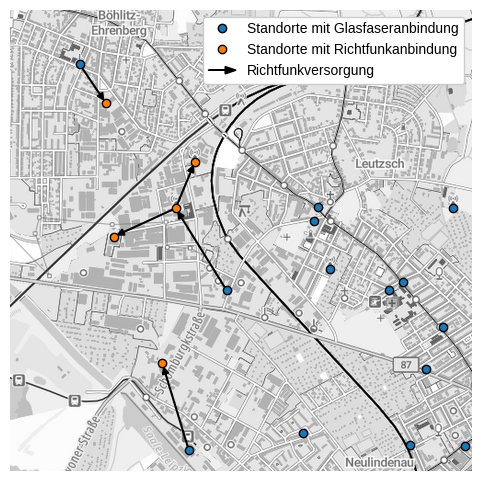

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.tight_layout(pad=0)

transformer = pyproj.Transformer.from_crs(CRS_WEBMERCATOR, CRS_WGS84_GPS)
center_x, center_y = transformer.transform(51.34651553275029, 12.305525800657593, direction="INVERSE")
offset = 2400
extent = box(center_x - offset, center_y - offset, center_x + offset, center_y + offset)

def plot_microwave_connections(ax: Axes, area_of_interest, gdf_sites):
    ax.set_axis_off()
    plot_tilemap(ax, area_of_interest)

    gdf_sites = gdf_sites.to_crs(CRS_WEBMERCATOR) 
    for _, site in gdf_sites[gdf_sites.within(area_of_interest)].iterrows():
        if site.connection == "Microwave":
            parent_site = gdf_sites.loc[site.connection_provided_by]
            color = "tab:orange"
            ax.annotate("",
                xytext=(parent_site.geometry.x, parent_site.geometry.y),
                xy=(site.geometry.x, site.geometry.y),
                arrowprops=dict(arrowstyle="-|>", linewidth=1.5, facecolor="black", edgecolor="black"),
                zorder=2,
                annotation_clip=False,
                clip_on=True
            )
        else:
            color = "tab:blue"

        ax.plot(site.geometry.x, site.geometry.y, marker="o", markersize=6, color=color, zorder=3, markeredgecolor="black")

    ax.legend(handles=[
        mlines.Line2D([], [], marker="o", linewidth=0, color="tab:blue", markersize=6, markeredgecolor="black", label=f"Standorte mit Glasfaseranbindung"),
        mlines.Line2D([], [], marker="o", linewidth=0, color="tab:orange", markersize=6, markeredgecolor="black", label="Standorte mit Richtfunkanbindung"),
        mpatches.FancyArrow(0, 0, 0, 0, edgecolor="black", facecolor="black", label="Richtfunkversorgung"),
    ], handler_map={mpatches.FancyArrow: HandlerPatch(patch_func=make_legend_arrow)}).get_frame().set_alpha(1)

plot_microwave_connections(ax, extent, gdf_sites)